In [1]:
import numpy as np
from keras.preprocessing import image
import tensorflow as tf
import cv2
from PIL import Image

In [ ]:
print("initializing...")
model = tf.keras.models.load_model('Model')
print("model ready!!")

In [ ]:
'''cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    test_image = Image.fromarray(frame, 'RGB')
    test_image = test_image.resize((224,224))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)/255
    result = model.predict(test_image)
    if np.argmax(result[0])==0:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.putText(frame, 'Fire Detected', (10,10),cv2.FONT_HERSHEY_COMPLEX_SMALL,1, (0, 255, 0), 1, cv2.LINE_AA)
    
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()'''

In [ ]:
test_image = image.load_img('home.jpeg', target_size = (224,224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)/255
result = model.predict(test_image)
print(result)
print(np.argmax(result[0])==0, max(result[0]))

In [ ]:
test_image = image.load_img('433.jpg', target_size = (224,224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)/255
result = model.predict(test_image)
print(result)
print(np.argmax(result[0])==0, max(result[0]))

------------------------------------------------------------------------------------------------------------------------------

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def display(img,cmap=None):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap=cmap)

In [3]:
def rgbMean(img):
    #fire = cv2.imread('18.jpg', cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img, (224, 224))
    rsum=0
    gsum=0
    bsum = 0
    for x in range(0,224):
        for y in range(0,224):
            rsum += img[x][y][0]
            gsum += img[x][y][1]
            bsum += img[x][y][2]
    rmean = float("{:.2f}".format(rsum/(224*224)))
    gmean = float("{:.2f}".format(gsum/(224*224)))
    bmean = float("{:.2f}".format(bsum/(224*224))) 

    return rmean, gmean, bmean

    #print(f"rmean = {rmean} \ngmean = {gmean} \nbmean = {bmean}")

In [4]:
fire = cv2.imread('image_146.jpg', cv2.IMREAD_UNCHANGED)
fire = cv2.resize(fire, (224, 224))
blur = cv2.GaussianBlur(fire, (21, 21), 0)
hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)
# #251, 183, 65
# lower = [18, 50, 50]
# upper = [35, 255, 255]
# # lower = [0, 75, 200]
# # upper = [18, 166, 230]
# lower = np.array(lower, dtype="uint8")
# upper = np.array(upper, dtype="uint8")
# #mask = cv2.inRange(hsv, lower, upper)
rmean, gmean, bmean = rgbMean(fire)
mask = fire.copy()
for x in range(0,224):
    for y in range(0,224):
        if mask[x][y][0] < rmean and mask[x][y][1] > gmean and mask[x][y][2] > bmean:
            mask[x][y] = 255
        else:
            mask[x][y] = 0

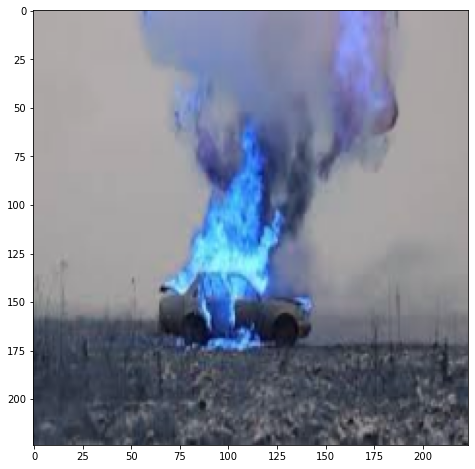

In [5]:
display(fire)

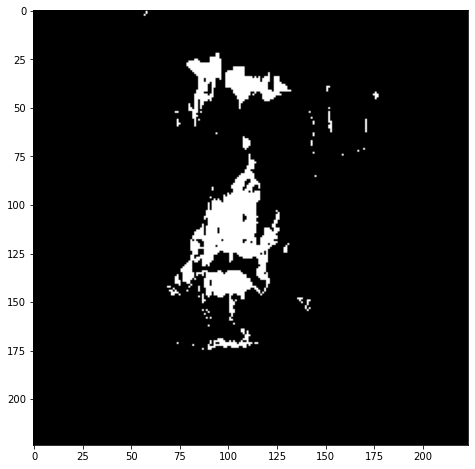

In [6]:
display(mask)

In [8]:
def getCoords(coords):
    fincord = [224,224]
    mid = [fire.shape[0]/2, fire.shape[1]/2]
    for x in coords['x']:
        if(abs(x-mid[0]) < abs(fincord[0]-mid[0])):
            fincord[0] = x
        
    for y in coords['y']:
        if(abs(y-mid[1]) < abs(fincord[1]-mid[1])):
            fincord[1] = y
            

    return fincord

In [9]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(mask,cv2.MORPH_OPEN,kernel, iterations = 2)
sure_bg = cv2.dilate(opening,kernel,iterations=3)
sure_bg = cv2.cvtColor(sure_bg, cv2.COLOR_RGB2GRAY)
open_gray = cv2.cvtColor(opening, cv2.COLOR_BGR2GRAY)
dist_transform = cv2.distanceTransform(open_gray,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0
markers = cv2.watershed(fire,markers)
contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

coords = {'x': [], 'y': [], 'w': [],'h': []}
for cntr in contours:
    x,y,w,h = cv2.boundingRect(cntr)
    coords['x'].append(x)
    coords['y'].append(y)
    coords['w'].append(w)
    coords['h'].append(h)

print(coords)

{'x': [100, 98, 87, 85, 1], 'y': [136, 134, 87, 85, 1], 'w': [11, 15, 30, 34, 222], 'h': [12, 16, 41, 45, 222]}


In [10]:
crd = getCoords(coords= coords)
x = crd[0]
y = crd[1]
w = 10
h = 10

print(crd)

im2 = cv2.rectangle(fire.copy(), (x, y), (x+w, y+h), (0, 0, 255), 2)

im2 = cv2.putText(im2, '('+str(x)+', '+str(y)+')',(x+w,y),
                  cv2.FONT_HERSHEY_COMPLEX_SMALL,0.5,
                 (0, 255, 0), 1, cv2.LINE_AA)

[100, 134]


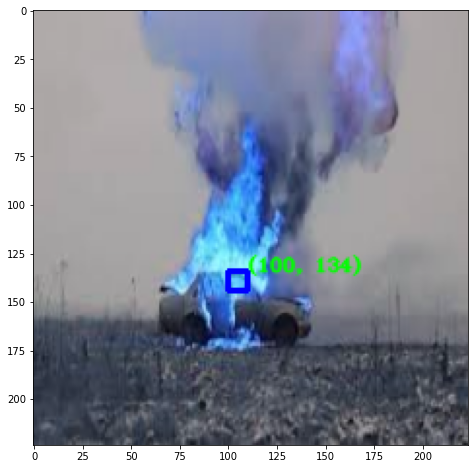

In [11]:
display(im2)  

In [ ]:
'''
for cnt in contours :
  
    approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)
  
    # draws boundary of contours.
    cv2.drawContours(img2, [approx], 0, (0, 0, 255), 5) 
  
    # Used to flatted the array containing
    # the co-ordinates of the vertices.
    n = approx.ravel() 
    i = 0
  
    for j in n :
        if(i % 2 == 0):
            x = n[i]
            y = n[i + 1]
  
            # String containing the co-ordinates.
            string = str(x) + " " + str(y) 
  
            if(i == 0):
                # text on topmost co-ordinate.
                cv2.putText(img2, "Arrow tip", (x, y),
                                font, 0.5, (255, 0, 0)) 
            else:
                # text on remaining co-ordinates.
                cv2.putText(img2, string, (x, y), 
                          font, 0.5, (0, 255, 0)) 
        i = i + 1






fire = cv2.imread('18.jpg')
fire = cv2.resize(fire, (224, 224))
blur = cv2.GaussianBlur(fire, (21, 21), 0)
hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)
#251, 183, 65
lower = [18, 50, 50]
upper = [35, 255, 255]
# lower = [0, 75, 200]
# upper = [18, 166, 230]
lower = np.array(lower, dtype="uint8")
upper = np.array(upper, dtype="uint8")
mask = cv2.inRange(hsv, lower, upper)
output = cv2.bitwise_and(fire, hsv, mask=mask)
  '''